# North Atlantic O2 analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw

In [2]:
# access model output
model = 'GFDL-ESM4'
dir = '/glade/work/ito/dataset/model/'+model+'/'
ds0=xr.open_dataset(dir+'o2_'+model+'_196501-201412_subsampled.nc')
ds1=xr.open_dataset(dir+'so_'+model+'_196501-201412_subsampled.nc')
ds2=xr.open_dataset(dir+'thetao_'+model+'_196501-201412_subsampled.nc')

In [3]:
# basin mask
dsm=xr.open_dataset('/glade/work/ito/dataset/model/basin_mask_01.nc')
# observation coordinates
dsd=xr.open_dataset('/glade/work/ito/dataset/model/mask_woagrid_196501-201412.nc')

In [4]:
# select depth level
zlev=500

In [5]:
# get coordinates
x=ds0.lon.to_numpy()
y=ds0.lat.to_numpy()
xi=np.arange(0,360,1)
yi=np.arange(0,180,1)
xx,yy=np.meshgrid(x,y)
xxi,yyi=np.meshgrid(xi,yi)

In [6]:
# calculate stratification
so=ds1.so.to_numpy()
to=ds2.thetao.to_numpy()
zo=ds1.depth.to_numpy()
rho=gsw.sigma0(so,to)
drdz=np.zeros((600,19,180,360))
for k in np.arange(1,18,1):
    dz=zo[k-1]-zo[k+1]
    dr=rho[:,k-1,:,:]-rho[:,k+1,:,:]
    drdz[:,k,:,:]=dr/dz

In [7]:
# !!! adhoc fix for layer 2 !!!
drdz[:,1,:,:]=drdz[:,2,:,:]

In [8]:
# extract data in the Atlantic basin at 500m depth
mask= dsm.basin_mask.sel(depth=zlev)
o2 = ds0.o2.sel(depth=zlev)*1e3
so = ds1.so.sel(depth=zlev)
to = ds2.thetao.sel(depth=zlev)
K = (zo==zlev)
dr = np.squeeze(drdz[:,K,:,:])

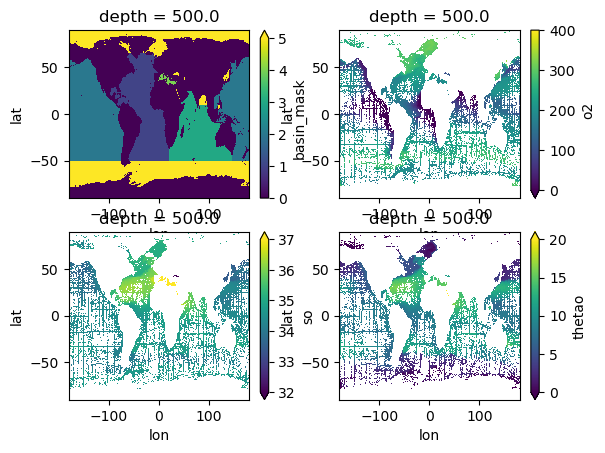

In [9]:
# take a look at the data
fig,ax=plt.subplots(2,2)
mask.plot(ax=ax[0,0],vmin=0,vmax=5,label='basin_mask')
o2.mean('time').plot(ax=ax[0,1],vmin=0,vmax=400,label='O2')
so.mean('time').plot(ax=ax[1,0],vmin=32,vmax=37,label='S')
to.mean('time').plot(ax=ax[1,1],vmin=0,vmax=20,label='T')

In [10]:
# select Atlantic basin
# Atlantic is mask = 1
ma = dsm.basin_mask.sel(depth=zlev).to_numpy()

In [11]:
# monthly climatology
#dc0=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_all_o00_01.nc',decode_times=False)
#dc1=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_decav_s00_01.nc',decode_times=False)
#dc2=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_decav_t00_01.nc',decode_times=False)
dc0=xr.open_dataset(dir+'o2_'+model+'_196501-201412.nc')
dc1=xr.open_dataset(dir+'so_'+model+'_196501-201412.nc')
dc2=xr.open_dataset(dir+'thetao_'+model+'_196501-201412.nc')

In [12]:
# extract 500m climatology
o2c=dc0.o2.sel(depth=zlev).groupby('time.month').mean('time')*1e3
soc=dc1.so.sel(depth=zlev).groupby('time.month').mean('time')
toc=dc2.thetao.sel(depth=zlev).groupby('time.month').mean('time')
# calculate stratification climatology
som=dc1.so.groupby('time.month').mean('time').to_numpy()
tom=dc2.thetao.groupby('time.month').mean('time').to_numpy()
rho=gsw.sigma0(som,tom)
drdzc=np.zeros((12,19,180,360))
for k in np.arange(1,18,1):
    dz=zo[k-1]-zo[k+1]
    drc=rho[:,k-1,:,:]-rho[:,k+1,:,:]
    drdzc[:,k,:,:]=drc/dz

In [13]:
# remove near-surface NaNs (!!! ad hoc fix !!!)
drdzc[:,1,:,:]=drdzc[:,2,:,:]

In [14]:
# subtract climatology from the discrete data to define anomalies
doa=o2.groupby('time.month')-o2c
dsa=so.groupby('time.month')-soc
dta=to.groupby('time.month')-toc
drc = np.squeeze(drdzc[:,K,:,:])
dra=dr - np.tile(drc,(50,1,1))
#
# make numpy array
doa = doa.to_numpy()
dsa = dsa.to_numpy()
dta = dta.to_numpy()
#
# prepare lat lon data
xx1 = np.tile(xx,[600,1,1])
yy1 = np.tile(yy,[600,1,1])

In [15]:
# apply mask for the north atlantic
doa=np.where((ma==1)&(yy>0),doa,np.nan)
dsa=np.where((ma==1)&(yy>0),dsa,np.nan)
dta=np.where((ma==1)&(yy>0),dta,np.nan)
dra=np.where((ma==1)&(yy>0),dra,np.nan)

In [16]:
# create data vector
doa0 = doa.flatten()
dsa0 = dsa.flatten()
dta0 = dta.flatten()
dra0 = dta.flatten()
xx0  = xx1.flatten()
yy0  = yy1.flatten()

In [17]:
# remove nan
dd = doa0 + dsa0 + dta0 + dra0
doa1=doa0[np.isnan(dd)==False]
dsa1=dsa0[np.isnan(dd)==False]
dta1=dta0[np.isnan(dd)==False]
dra1=dra0[np.isnan(dd)==False]
xx1=xx0[np.isnan(dd)==False]
yy1=yy0[np.isnan(dd)==False]
Nsample = np.size(doa1)
print(Nsample)

23934


In [18]:
# generate data matrix and standardize it
X = np.array([dsa1, dta1, dra1, xx1, yy1])
y = doa1
Xm = np.mean(X,axis=1)
Xstd = np.std(X,axis=1)
N=np.size(y)
Xa = (X.T - Xm)/Xstd
ym = np.mean(y)
ystd = np.std(y)
ya = (y-ym)/ystd

In [19]:
##
## Multiple Linear Regression
##
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xa, ya,random_state=1)

In [20]:
# fit model
MLregr = LinearRegression().fit(X_train, y_train)
#MLregr.coef_
#MLregr.intercept_
out=MLregr.predict(X_test)

0.22685589966253394
correlation =  0.47632596030858826


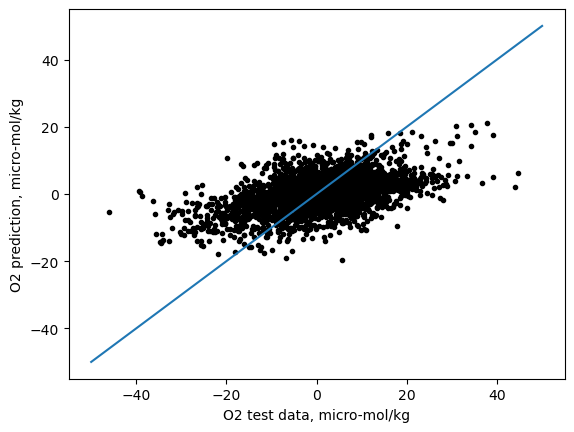

In [21]:
# test model output
score=MLregr.score(X_test, y_test)
print(score)
o2est = out*ystd + ym
o2test= y_test*ystd + ym
plt.plot(o2test,o2est,'k.')
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_MLR=temp[0,1]
print('correlation = ',Rval_MLR)

In [22]:
##
## Support Vector Regression
##
import sklearn.svm as svm

In [23]:
SVregr = svm.SVR(C=5)
SVregr.fit(X_train, y_train)

SVR(C=5)

In [24]:
out = SVregr.predict(X_test)
SVregr.score(X_test, y_test)

0.5172579308152279

correlation =  0.7199089852651629


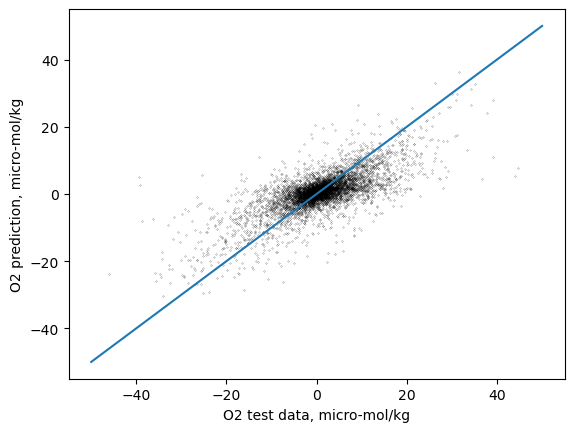

In [25]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_SV=temp[0,1]
print('correlation = ',Rval_SV)

In [26]:
SVregr.get_params()

{'C': 5,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [27]:
## NN
from sklearn.neural_network import MLPRegressor

In [28]:
# shallow NN 5-5
sNNregr = MLPRegressor(hidden_layer_sizes=(5,5),random_state=1, max_iter=500).fit(X_train, y_train)

In [29]:
out = sNNregr.predict(X_test)
sNNregr.score(X_test, y_test)

0.4142409411043685

In [30]:
# deep NN 30-30-30-5
NNregr = MLPRegressor(hidden_layer_sizes=(30,30,30,5),random_state=1, max_iter=500).fit(X_train, y_train)

In [31]:
out = NNregr.predict(X_test)
NNregr.score(X_test, y_test)

0.6190357636898252

correlation =  0.7875327493160335
RMSE =  5.04456111754141


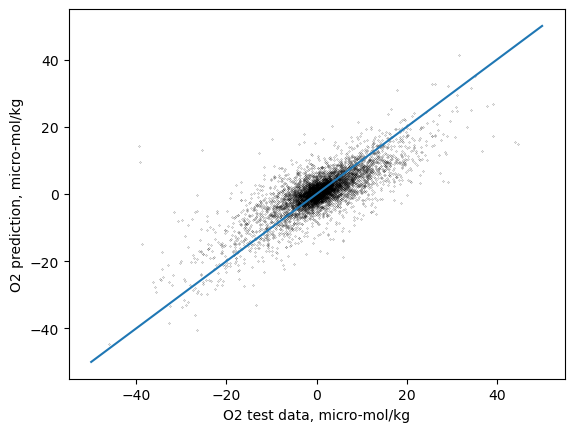

In [32]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_NN=temp[0,1]
print('correlation = ',Rval_NN)
RMSE_NN=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_NN)

Text(0, 0.5, 'Loss function')

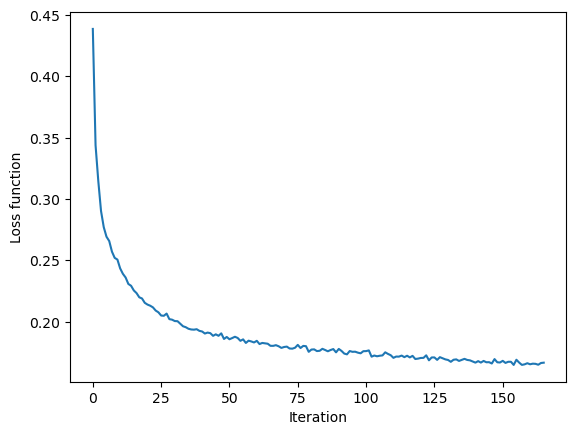

In [33]:
# plot the loss function
plt.plot(NNregr.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss function')

In [34]:
NNregr.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (30, 30, 30, 5),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

## mapping O2 using NN

In [35]:
# NN model
year = 1978
month = 6
it = month+(year-1965)*12-1
print('time index = '+str(it))

time index = 161


In [36]:
# prepare TS input, prepare O2 test data
soa=dc1.so.isel(time=it).sel(depth=zlev)-soc[month-1,:,:]
toa=dc2.thetao.isel(time=it).sel(depth=zlev)-toc[month-1,:,:]
o2a=dc0.o2.isel(time=it).sel(depth=zlev)*1e3-o2c[month-1,:,:]

In [37]:
# calculate stratification anomaly
som=dc1.so.isel(time=it).to_numpy()
tom=dc2.thetao.isel(time=it).to_numpy()
rho=gsw.sigma0(som,tom)
drdz0=np.zeros((19,180,360))
for k in np.arange(1,18,1):
    dz=zo[k-1]-zo[k+1]
    dr0=rho[k-1,:,:]-rho[k+1,:,:]
    drdz0[k,:,:]=dr0/dz
drdza0=drdz0 - drdzc[month-1,:,:,:]
dra=np.squeeze(drdza0[K,:,:])

In [38]:
# take a look at the data
#fig,ax=plt.subplots(2,2)
#ax[0,0].pcolormesh(xx,yy,toa,cmap='RdBu_r',vmin=-3,vmax=3)
#ax[0,1].pcolormesh(xx,yy,soa,cmap='RdBu_r',vmin=-.3,vmax=.3)
#ax[1,0].pcolormesh(xx,yy,dra,cmap='RdBu_r',vmin=-.003,vmax=.003)
#ax[1,1].pcolormesh(xx,yy,o2a,cmap='RdBu_r',vmin=-30,vmax=30)

In [39]:
# apply mask for the north atlantic
doa=np.where((ma==1)&(yy>0),o2a,np.nan)
dsa=np.where((ma==1)&(yy>0),soa,np.nan)
dta=np.where((ma==1)&(yy>0),toa,np.nan)
dra=np.where((ma==1)&(yy>0),dra,np.nan)

In [40]:
# take a look at the data
#fig,ax=plt.subplots(2,2)
#ax[0,0].pcolormesh(xx,yy,dta,cmap='RdBu_r',vmin=-3,vmax=3)
#ax[0,1].pcolormesh(xx,yy,dsa,cmap='RdBu_r',vmin=-.3,vmax=.3)
#ax[1,0].pcolormesh(xx,yy,dra,cmap='RdBu_r',vmin=-.003,vmax=.003)
#ax[1,1].pcolormesh(xx,yy,doa,cmap='RdBu_r',vmin=-30,vmax=30)

In [41]:
# create data vector
doa0 = doa.flatten()
dsa0 = dsa.flatten()
dta0 = dta.flatten()
dra0 = dta.flatten()
xx0  = xx.flatten()
yy0  = yy.flatten()
xi0  = xxi.flatten()
yi0  = yyi.flatten()

In [42]:
# remove nan
dd = dsa0 + dta0 + dra0 + doa0
doa1=doa0[np.isnan(dd)==False]
dsa1=dsa0[np.isnan(dd)==False]
dta1=dta0[np.isnan(dd)==False]
dra1=dra0[np.isnan(dd)==False]
xx1=xx0[np.isnan(dd)==False]
yy1=yy0[np.isnan(dd)==False]
xi1=xi0[np.isnan(dd)==False]
yi1=yi0[np.isnan(dd)==False]
Nsample = np.size(dsa1)
print(Nsample)

3432


In [43]:
# generate data matrix and standardize it
X = np.array([dsa1, dta1, dra1, xx1, yy1])
Xa = (X.T - Xm)/Xstd

In [44]:
# projection
out = NNregr.predict(Xa)
outMLR = MLregr.predict(Xa)
outSVR = SVregr.predict(Xa)
outSNN=sNNregr.predict(Xa)

In [45]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=out[n]
o2estNN = temp*ystd + ym
RMSE_DNN=np.sqrt(np.mean((out*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,out)
R_DNN=temp[0,1]

In [46]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=outMLR[n]
o2estMLR = temp*ystd + ym
RMSE_MLR=np.sqrt(np.mean((outMLR*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,outMLR)
R_MLR=temp[0,1]

In [47]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=outSVR[n]
o2estSVR = temp*ystd + ym
RMSE_SVR=np.sqrt(np.mean((outSVR*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,outSVR)
R_SVR=temp[0,1]

In [48]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=outSNN[n]
o2estSNN = temp*ystd + ym
RMSE_SNN=np.sqrt(np.mean((outSNN*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,outSNN)
R_NN=temp[0,1]

Text(0.5, 1.0, 'RMSE')

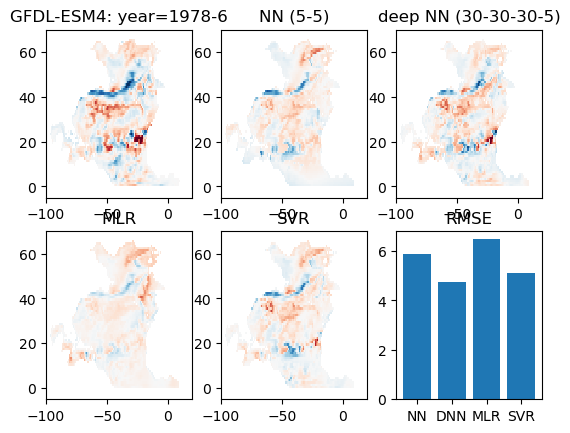

In [49]:
dat = dsd.isel(time=it).sel(depth=zlev)

fig,ax=plt.subplots(2,3)
ax[0,0].pcolormesh(xx,yy,doa,vmin=-30,vmax=30,cmap='RdBu_r')
dpos=dat.mask.to_numpy()
xxx=np.where((ma==1)&(yy>0),xx,np.nan)
yyy=np.where((ma==1)&(yy>0),yy,np.nan)
xpos=xxx[dpos==1]
ypos=yyy[dpos==1]
#ax[0,0].scatter(xpos, ypos, s=20, facecolors='none', edgecolors='k')
ax[0,0].set_xlim(-100,20)
ax[0,0].set_ylim(-5,70)
ax[0,0].set_title(model+': year='+str(year)+'-'+str(month))
#
ax[0,1].pcolormesh(xx,yy,o2estSNN,vmin=-30,vmax=30,cmap='RdBu_r')
ax[0,1].set_xlim(-100,20)
ax[0,1].set_ylim(-5,70)
ax[0,1].set_title('NN (5-5)')
#
ax[0,2].pcolormesh(xx,yy,o2estNN,vmin=-30,vmax=30,cmap='RdBu_r')
ax[0,2].set_xlim(-100,20)
ax[0,2].set_ylim(-5,70)
ax[0,2].set_title('deep NN (30-30-30-5)')
#
#ax[0,2].pcolormesh(xx,yy,o2est-doa,vmin=-30,vmax=30,cmap='RdBu_r')
#ax[0,2].set_xlim(-100,20)
#ax[0,2].set_ylim(-5,70)
#ax[0,2].set_title('bias')
#
ax[1,0].pcolormesh(xx,yy,o2estMLR,vmin=-30,vmax=30,cmap='RdBu_r')
ax[1,0].set_xlim(-100,20)
ax[1,0].set_ylim(-5,70)
ax[1,0].set_title('MLR')
#
ax[1,1].pcolormesh(xx,yy,o2estSVR,vmin=-30,vmax=30,cmap='RdBu_r')
ax[1,1].set_xlim(-100,20)
ax[1,1].set_ylim(-5,70)
ax[1,1].set_title('SVR')
#
ax[1,2].bar(['NN','DNN','MLR','SVR'],[RMSE_SNN,RMSE_DNN,RMSE_MLR,RMSE_SVR])
ax[1,2].set_title('RMSE')
#ax[1,2].bar(['NN','DNN','MLR','SVR'],[R_NN,R_DNN,R_MLR,R_SVR])